In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import median_filter
###########################
# Setup Plotting Defaults #
###########################
# For more options see https://matplotlib.org/users/customizing.html

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.dpi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid', 'navy', 'brown'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Helvetica'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'
mpl.rcParams['text.usetex'] = True

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 24
mpl.rcParams['axes.labelpad'] = 10.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.8
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
#mpl.rcParams['figure.figsize'] = 10, 6

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

In [2]:
MLim = np.loadtxt("../stored_limits/BlackHoleSpins_Baryakhtar.txt")
DLim = np.loadtxt("../stored_limits/BlackHoleSpins_Mehta.txt")
ULim = np.loadtxt("../stored_limits/BlackHoleSpins_Unal.txt")

In [334]:
def get_limit(fname, binN=400, binW=0.02, cl=90, minB=-13, maxB=-10, asymT=10, smth=True, wid=7, thr=16):
    fileMCMC = np.loadtxt("../output_mcmc/"+fname)
    binC = np.linspace(minB , maxB, binN)
   
    limV = np.zeros_like(binC)

    thresholdV = thr
    startadd = False
    endadd = False

    for i in range(len(binC) ):
        cond1 = fileMCMC[:,0] >= binC[i] - binW
        cond2 = fileMCMC[:,0] <= binC[i] + binW
        cond3 = fileMCMC[:,0] <= binC[i] 
        cond4 = fileMCMC[:,0] >= binC[i] 


        shortL = fileMCMC[np.all(np.column_stack((cond1, cond2)), axis=1), :]
        if len(shortL) < 5:
            limV[i] = 19
        else:
            # test asymmetry
            shortUp = fileMCMC[np.all(np.column_stack((cond1, cond3)), axis=1), :]
            shortLow = fileMCMC[np.all(np.column_stack((cond2, cond4)), axis=1), :]

            if len(shortUp) > 0:
                upperA = np.percentile(shortUp[:,1], cl)
            else:
                # print(len(shortL))
                upperA = np.percentile(shortL[:,1], cl)
            if len(shortLow) > 0:
                lowerA = np.percentile(shortLow[:,1], cl)
            else:
                upperA = np.percentile(shortL[:,1], cl) 
    #        limV[i] = np.mean([upperA, lowerA])

            medval = np.percentile(shortL[:,1], cl)
            metricV =   ( (upperA - lowerA) / (lowerA + upperA) / 2 * 100 )
    #        print(binC[i], medval, upperA, lowerA, metricV)
            if metricV > asymT:
                # print(binC[i], medval, lowerA)
                limV[i] = lowerA # np.percentile(upperA, cl)
            elif metricV < -asymT:
                # print(binC[i], medval, upperA)
                limV[i] = upperA # np.percentile(lowerA, cl)
            else:
                limV[i] = medval # np.percentile(shortL[:,1], cl)
        
        

    if smth:
        out = savgol_filter(limV, wid, 1)
        for i in range(len(out)):
            if (out[i] > thresholdV)and(not startadd):
                out[i] = 19.0
            elif (out[i] < thresholdV)and(not startadd):
                startadd = True
            
            if startadd and (out[i] > thresholdV):
                endadd = True
            if endadd:
                out[i] = 19.0

        return 10**binC, 1.0 / 10**out
    else:
        return 10**binC, 1.0 / 10**limV

def extract_unique_2d_elements(arr):
    # Convert the array to a set of tuples to ensure uniqueness
    unique_elements = {tuple(row) for row in arr}
    
    # Convert the set of tuples back to a list of lists (2D array format)
    unique_2d_array = [list(elem) for elem in unique_elements]
    
    return unique_2d_array



In [289]:
print(np.shape(fileMCMC))

(105900, 2)


In [335]:
nm="Me_GRS_Rel_N5.dat"
binN=600
binW=0.05
cl=95
asymT=1e100
wid=30
smth=True
minB=np.log10(1.3e-13)
maxB=np.log10(2e-11)


fileMCMC = np.loadtxt("../output_mcmc/"+nm)

massMi = 3.0e-13
massMa = 8e-12
faMi=1e14
cond = np.all(np.column_stack((fileMCMC[:,1] > np.log10(faMi), fileMCMC[:,0]>np.log10(massMi), fileMCMC[:,0]<np.log10(massMa))), axis=1)
# cut
# np.savetxt("../output_mcmc/"+nm, fileMCMC[~cond])
# fileMCMC = np.loadtxt("../output_mcmc/"+nm)

# non_redund = extract_unique_2d_elements(fileMCMC)
# np.savetxt("../output_mcmc/"+nm, non_redund)


MeB, MeL = get_limit(nm, binN=binN, binW=binW, cl=cl, asymT=asymT, minB=minB, maxB=maxB, smth=smth, wid=wid)
### SVE?
np.savetxt("../stored_limits/"+nm, np.column_stack((MeB, MeL)))
# np.savetxt("../stored_limits_fake/"+nm, np.column_stack((MeB, MeL)))

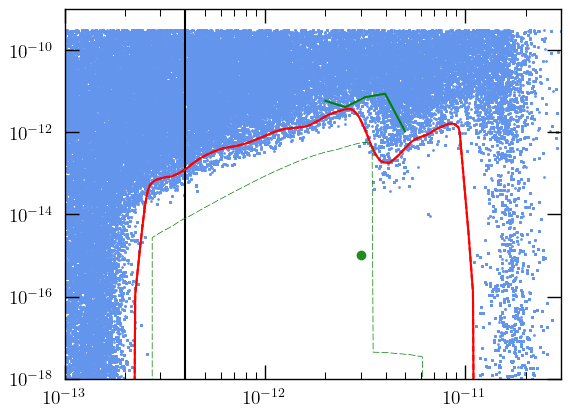

In [336]:
## Sanity check

fileMCMC = np.loadtxt("../output_mcmc/"+nm)
plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=1)

test = np.loadtxt("../stored_limits/"+nm)
# test = np.loadtxt("../stored_limits_fake/"+nm)
plt.plot(test[:,0], test[:,1],"r")

# plt.scatter(10**non_redund[:,0], 1.0 / 10**non_redund[:,1], s=.1)

plt.vlines(4e-13, 0, 1, color="k")
plt.scatter([3e-12], [1/1e15])

plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-18, 1e-9])
plt.xlim([1e-13, 3e-11])

cc = np.loadtxt("../test_store/estim_lim_Cyg_Rel.dat")
plt.plot(cc[:,0], 1/cc[:,1],"g")

# test = np.loadtxt("../stored_limits/Me_CygX1_Rel_N3.dat")
# test = np.loadtxt("../stored_limits/Me_GRO_Rel_N3.dat")
# test = np.loadtxt("../stored_limits/Doddy_GRS_Rel_N3_2.dat")
plt.plot(test[:,0], test[:,1],"r", ls="dashed")

MashaB = np.loadtxt("../stored_limits/BlackHoleSpins_Baryakhtar.txt")
plt.plot(MashaB[:,0], MashaB[:,1] * 1, "g", lw=.5, ls=(5, (10, 3)))


(1e-13, 3e-11)

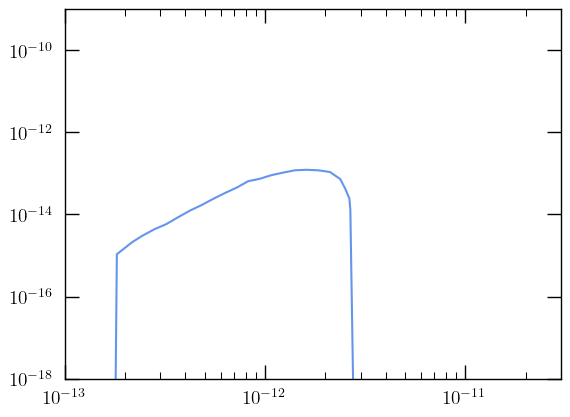

In [312]:
loadH = np.loadtxt("../stored_limits/raw_hoof_lim.dat")
plt.plot(loadH[:,0], loadH[:,1])
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-18, 1e-9])
plt.xlim([1e-13, 3e-11])

Text(0, 0.5, '$1/f_a$   [${\\rm GeV^{-1}}$]')

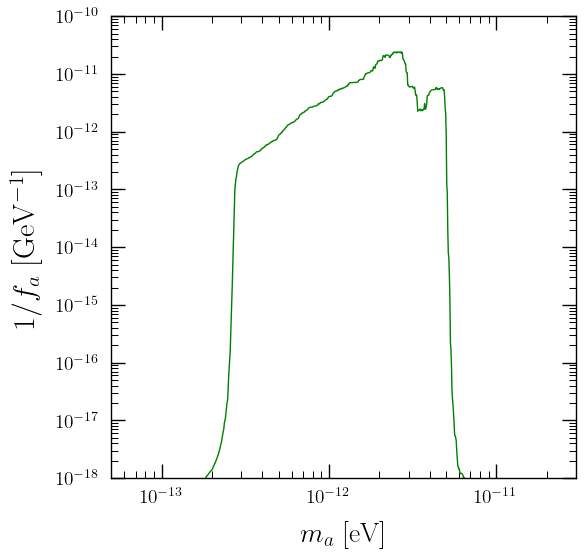

In [31]:
fig, ax = plt.subplots(1, figsize=(6,6))



# ax.fill_between(MeB, MeL, 1e100, color="#28B188",ec="k", alpha=0.5)
# ax.plot(MeB2, MeL2, "k")
# ax.plot(MeLSmooth[:,1], MeLSmooth[:,0], "#28B188")
ref = 1.0
ax.plot(MeB, MeL, "g", lw=1)

#plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=1)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_ylim([1e-18, 1e-10])
ax.set_xlim([5e-14, 3e-11])
ax.set_xlabel(r"$m_a$   [eV]", fontsize=20)
ax.set_ylabel(r"$1/f_a$   [${\rm GeV^{-1}}$]", fontsize=22)

array([[6.77427090e-12, 5.83754776e+15],
       [6.77427090e-12, 5.83754776e+15],
       [7.51973062e-12, 2.89909980e+14],
       ...,
       [7.52575919e-12, 1.56105948e+16],
       [7.52575919e-12, 1.56105948e+16],
       [7.52575919e-12, 1.56105948e+16]])

115000 39950


In [49]:
# fileIn = "Me_Cyg_Conserve2_stacked.dat"
# fileIn = "Me_GRS_N4_stacked.dat"
fileIn = "Me_Cyg_NEW_stacked.dat"
binN=600
binW=0.07
cl=93
asymT=10
minB=-13
maxB=np.log10(2e-11)
pltB, pltL = get_limit(fileIn, binN=binN, binW=binW, cl=cl, asymT=asymT)
LSmooth = 10**savgol_filter(np.log10(pltL), 19, 3) # window size 51, polynomial order 3
# np.savetxt("../stored_limits/MashaCyg_mcmc_2.dat", np.column_stack((pltB, pltL)))
# np.savetxt("../stored_limits/Me_Cygx1_N4_CONS_2.dat", np.column_stack((pltB, pltL)))
np.savetxt("../stored_limits/Me_Cygx1_N4_NEW_2.dat", np.column_stack((pltB, pltL)))
# np.savetxt("../stored_limits/GRS_N4.dat", np.column_stack((pltB, pltL)))

In [45]:
# MeLSmooth = 10**savgol_filter(np.log10(MeL), 9, 3) # window size 51, polynomial order 3
# MeLSmooth = savgol_filter(MeL, 7, 3) # window size 51, polynomial order 3


In [46]:
#binN=400
#binW=0.02
#cl=99
#MashB, MashL = get_limit(fMasha1, binN=binN, binW=binW, cl=cl)
#DodB, DodL = get_limit(fDoddy1, binN=binN, binW=binW, cl=cl)
#MeB, MeL = get_limit(fMe1, binN=binN, binW=binW, cl=cl)
#MeB2, MeL2 = get_limit(fMe2, binN=binN, binW=binW, cl=99)

In [47]:
mecheck = np.loadtxt("../stored_limits/Me_cygx1_NEW.dat")
testCheck = np.loadtxt("../stored_limits/TEST_Cyg_FID.dat")

mecheck2 = np.loadtxt("../stored_limits/Me_Cygx1_N4_CONS_2.dat")
testCheck2 = np.loadtxt("../stored_limits/TEST_Cyg_Cns.dat")

mecheck3 = np.loadtxt("../stored_limits/GRS_N4.dat")
testCheck3 = np.loadtxt("../stored_limits/TEST_GRS.dat")

NameError: name 'pltB' is not defined

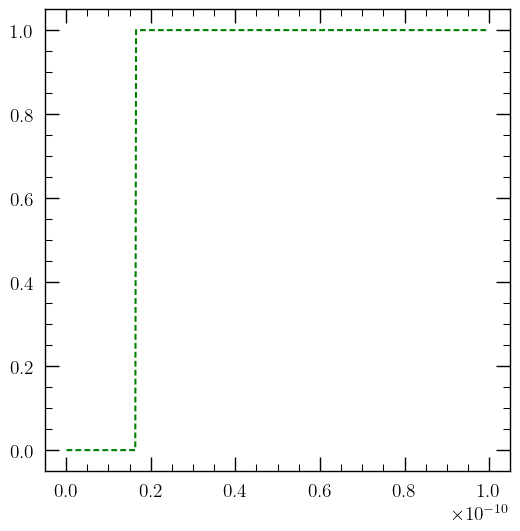

In [38]:
fig, ax = plt.subplots(1, figsize=(6,6))



# ax.fill_between(MeB, MeL, 1e100, color="#28B188",ec="k", alpha=0.5)
# ax.plot(MeB2, MeL2, "k")
# ax.plot(MeLSmooth[:,1], MeLSmooth[:,0], "#28B188")
ref = 1.0
ax.plot(MeB * ref, MeL, "g", ls="--")

ax.plot(pltB, pltL, "k", lw=1)
# ax.plot(pltB, LSmooth, "k", ls="--")

ax.set_yscale("log")
ax.set_xscale("log")

#ax.plot(MeCYGN4CONS[:,0], MeCYGN4CONS[:,1], "#6F1D1B", lw=1, ls="dotted")
ax.plot(testCheck3[:,0], 1/testCheck3[:,1], "#6F1D1B", lw=1, ls="dotted")
ax.plot(mecheck[:,0], mecheck[:,1], "k", lw=1, ls="dotted")


ax.plot(MLim[:,0], MLim[:,1], "#866DC5")
# ax.plot(MashaB, MashaL, "#866DC5", dashes=[2, 2, 6, 2])
ax.plot(DLim[:,0], DLim[:,1], "#FB8F67")
#ax.plot(DodB, DodL, "#FB8F67", dashes=[2, 2, 6, 2])
# ax.scatter([3e-13, 1e-12, 3e-12], [1 / 6e14, 1 / 1e13, 1/5e11], s=4)
ax.scatter([2.4e-13], [1 / 8e13], s=30)

#plt.plot(DLim[:,0], DLim[:,1])
ax.set_ylim([1e-18, 1e-10])
ax.set_xlim([5e-14, 3e-11])
ax.set_xlabel(r"$m_a$   [eV]", fontsize=20)
ax.set_ylabel(r"$1/f_a$   [${\rm GeV^{-1}}$]", fontsize=22)

binW=0.02
cl=95
MeB, MeL = get_limit(fMe2, binN=binN, binW=binW, cl=cl)

MeB2, MeL2 = get_limit(fMeFull, binN=binN, binW=2 * binW, cl=cl) 

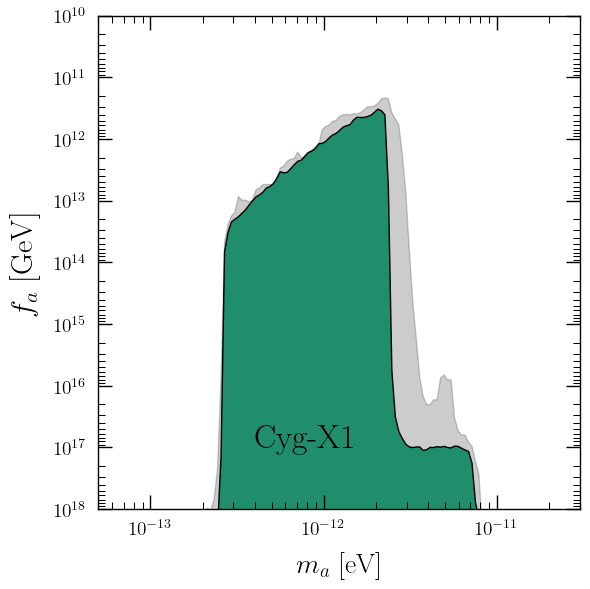

In [14]:
fig, ax = plt.subplots(1, figsize=(6,6))

# ax.plot(MashB, 1/MashL, "r")
# ax.plot(DodB, 1/DodL, "c")
ax.fill_between(MeB, 1/MeL, 1e100, color="#28B188",ec="k")
ax.fill_between(MeB2, 1/MeL2, 1e100, color="k", alpha=0.2,ec="k")
# ax.plot(MeB2, 1/ MeL2  , "g", ls="--")


ax.set_yscale("log")
ax.set_xscale("log")


# ax.plot(MLim[:,0], 1/MLim[:,1], "y")
# ax.plot(DLim[:,0], 1/DLim[:,1])


#plt.plot(DLim[:,0], DLim[:,1])
ax.set_ylim([1e18, 1e10])
ax.set_xlim([5e-14, 3e-11])
ax.set_xlabel(r"$m_a$   [eV]", fontsize=20)
ax.set_ylabel(r"$f_a$   [${\rm GeV}$]", fontsize=22)
ax.text(4e-13, 1e17, "Cyg-X1", fontsize=24);
plt.tight_layout()
# plt.savefig("OurLim.jpeg", dpi=200)

In [579]:
binN=400
binW=0.02
cl=99

# MashB, MashL = get_limit(fMasha1, binN=binN, binW=binW, cl=cl)
# MashBF, MashLF = get_limit(fMashaFull, binN=binN, binW=binW, cl=cl)
DodB, DodL = get_limit(fDoddy1, binN=binN, binW=binW, cl=cl)

In [580]:
np.savetxt("../stored_limits/Doddy_revisited.dat", np.column_stack((DodB, DodL)))

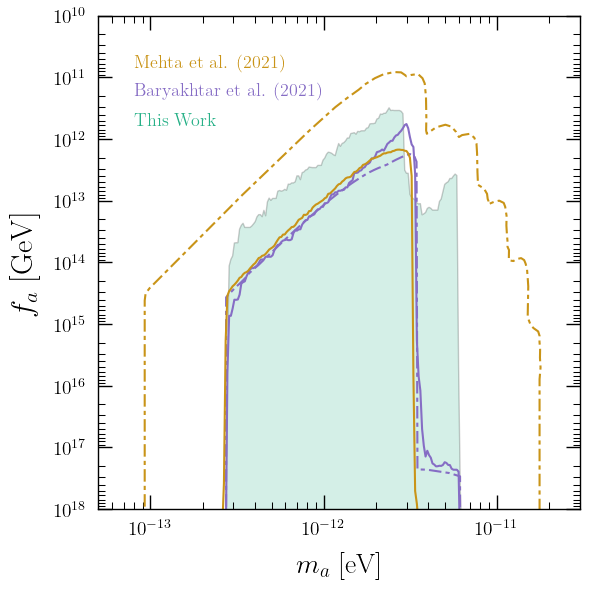

In [19]:
fig, ax = plt.subplots(1, figsize=(6,6))

# ax.plot(MashB, 1/MashL, "r")
# ax.plot(DodB, 1/DodL, "c")
ax.fill_between(MeB, 1/MeL, 1e100, color="#28B188",ec="k", alpha=0.2)
# ax.plot(MeB2, 1/ MeL2  , "g", ls="--")


ax.set_yscale("log")
ax.set_xscale("log")

ax.plot(MLim[:,0], 1/MLim[:,1], "#866DC5", dashes=[2, 2, 6, 2])
ax.plot(MashB, 1/MashL, "#866DC5")
# ax.plot(MashBF, 1/MashLF, "k", ls="--")
ax.plot(DLim[:,0], 1/DLim[:,1], "#C99418", dashes=[2, 2, 6, 2])
ax.plot(DodB, 1/DodL, "#C99418")


#plt.plot(DLim[:,0], DLim[:,1])
ax.set_ylim([1e18, 1e10])
ax.set_xlim([5e-14, 3e-11])
ax.set_xlabel(r"$m_a$   [eV]", fontsize=20)
ax.set_ylabel(r"$f_a$   [${\rm GeV}$]", fontsize=22)
ax.text(8e-14, 7e10, "Mehta et al. (2021)", fontsize=13, c="#C99418");
ax.text(8e-14, 2e11, "Baryakhtar et al. (2021)", fontsize=13, c="#866DC5");
ax.text(8e-14, 6e11, "This Work", fontsize=13, c="#28B188");
plt.tight_layout()
#plt.savefig("ComparisonLim.jpeg", dpi=200)

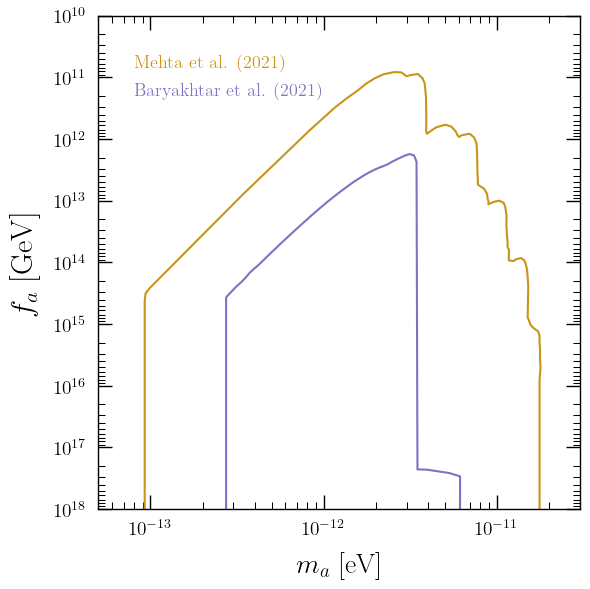

In [34]:
fig, ax = plt.subplots(1, figsize=(6,6))

ax.set_yscale("log")
ax.set_xscale("log")

ax.plot(MLim[:,0], 1/MLim[:,1], "#866DC5")
# ax.plot(MashB, 1/MashL, "#866DC5")
# ax.plot(MashBF, 1/MashLF, "k", ls="--")
ax.plot(DLim[:,0], 1/DLim[:,1], "#C99418")
# ax.plot(DodB, 1/DodL, "#C99418")


#plt.plot(DLim[:,0], DLim[:,1])
ax.set_ylim([1e18, 1e10])
ax.set_xlim([5e-14, 3e-11])
ax.set_xlabel(r"$m_a$   [eV]", fontsize=20)
ax.set_ylabel(r"$f_a$   [${\rm GeV}$]", fontsize=22)
ax.text(8e-14, 7e10, "Mehta et al. (2021)", fontsize=13, c="#C99418");
ax.text(8e-14, 2e11, "Baryakhtar et al. (2021)", fontsize=13, c="#866DC5");
# ax.text(8e-14, 6e11, "This Work", fontsize=13, c="#28B188");
plt.tight_layout()
plt.savefig("ComparisonLim_talk.jpeg", dpi=200)

In [10]:
np.shape(fileMCMC)

(10800, 2)

(5e-14, 4e-11)

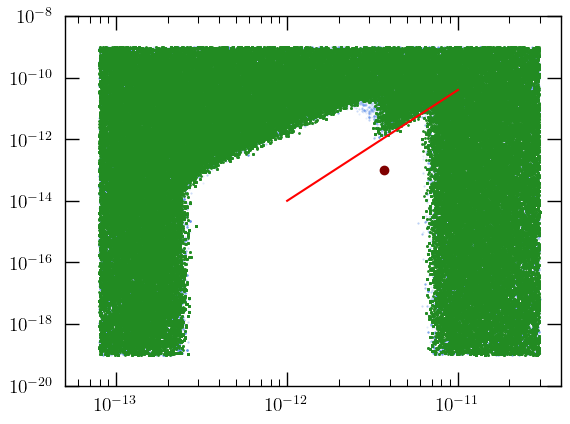

In [313]:
## Sanity check
fileMCMC = np.loadtxt("../output_mcmc/Doddy_stacked.dat")
fileMCMC2 = np.loadtxt("../output_mcmc/Doddy_stacked_2.dat")

#plt.plot(MashB, MashL, "r")
plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=.2, alpha=0.2)
plt.scatter(10**fileMCMC2[:,0], 1.0 / 10**fileMCMC2[:,1], s=1)

plt.scatter([3.7e-12], [1/1e13])

xx= np.logspace(-12, -11, 30)
plt.plot(xx, .4 * 1e-10 * (xx/1e-11)**(3.6), "r")

plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-20, 1e-8])
plt.xlim([5e-14, 4e-11])

In [4]:
# cygn4 = np.loadtxt("../stored_limits/TEST_Cyg_FID.dat")
cygn4C = np.loadtxt("../stored_limits/TEST_Cyg_Cns.dat")
# cygn4 = np.loadtxt("../stored_limits/TEST_GRS.dat")

# CygN4new = np.loadtxt("../stored_limits/Me_Cygx1_N4_NEW_2.dat")
CygN4new = np.loadtxt("../stored_limits/GRS_N4.dat")

(1e-13, 3e-11)

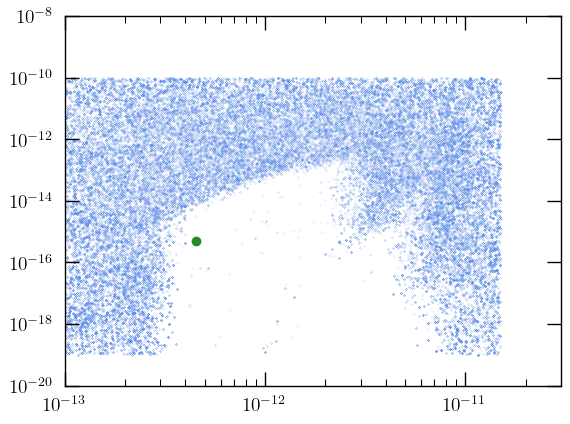

In [36]:
## Sanity check
fileMCMC = np.loadtxt("../output_mcmc/Me_LMC_N3_Rel.dat")
#fileMCMC2 = np.loadtxt("../output_mcmc/Me_Cyg_N4_NR.dat")
# fileMCMC = np.loadtxt("../output_mcmc/Me_Cyg_Conserve2_stacked.dat")
# fileMCMC = np.loadtxt("../output_mcmc/Me_GRS_N4_stacked.dat")
# fileMCMC = np.loadtxt("../output_mcmc/LowMassRegion_TauMax_5.0e6_alpha_maxmin_10.0_0.001_Me_v40__CygX1_Conserve_2_Nsamps_250__add411__mcmc.dat")

# 
#fileMCMC2 = np.loadtxt("../output_mcmc/LowMassRegion_TauMax_5.0e6_alpha_maxmin_1.0_0.001_Me_newRates__CygX1_Nsamps_100000__mcmc.dat")
#plt.plot(CygN4new[:,0], CygN4new[:,1], "r")
# plt.plot(cygn4[:,0], 1/cygn4[:,1], "r", ls="dotted")
#plt.plot(cygn4C[:,0], 1/cygn4C[:,1], "r", ls="dotted")


plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=.01)
#plt.scatter(10**fileMCMC2[:,0], 1.0 / 10**fileMCMC2[:,1], s=.01)
#plt.scatter(10**fileMCMC2[:,0], 1.0 / 10**fileMCMC2[:,1], s=.1, alpha=0.4)
# plt.plot(MeB, MeL, "g", ls="--")
plt.scatter([4.5e-13], [1/2e15])
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-20, 1e-8])
plt.xlim([1e-13, 3e-11])
# plt.vlines(7.9e-12, ymin=0,ymax=1)


In [298]:
fileMCMC

array([[-13.01767148,  17.26423559],
       [-12.92331165,  12.19235839],
       [-12.9388142 ,  14.22445215],
       ...,
       [-13.03210289,  12.11782295],
       [-11.09893337,  17.48492804],
       [-10.63818007,  11.96774631]])

array([[9.81961688e-13, 3.19607470e+17],
       [9.81961688e-13, 3.19607470e+17],
       [9.81961688e-13, 3.19607470e+17],
       [9.55042155e-13, 4.02895918e+17],
       [9.34520768e-13, 2.75195460e+18],
       [9.34520768e-13, 2.75195460e+18],
       [9.34520768e-13, 2.75195460e+18],
       [9.34520768e-13, 2.75195460e+18],
       [9.34520768e-13, 2.75195460e+18],
       [9.34520768e-13, 2.75195460e+18],
       [7.26011823e-13, 1.48313021e+17],
       [7.26011823e-13, 1.48313021e+17],
       [3.88290799e-13, 4.14596811e+18],
       [7.07242656e-13, 1.35944424e+16],
       [6.40328477e-13, 1.25218640e+18],
       [6.40328477e-13, 1.25218640e+18],
       [6.40328477e-13, 1.25218640e+18],
       [3.54495968e-13, 1.61184366e+16]])

In [1092]:
# np.savetxt("../output_mcmc/Me_Cyg_NEW_stacked.dat", fileMCMC[~cond])
np.savetxt("../output_mcmc/Me_Cyg_Conserve2_stacked.dat", fileMCMC[~cond])
#np.savetxt("../output_mcmc/Me_GRS_N4_stacked.dat", fileMCMC[~cond])

In [80]:
fMasha1 = "LowMassRegion_TauMax_5.0e6_alpha_maxmin_1.0_0.001_Masha__M33X7_Nsamps_100000__mcmc.dat"
fDoddy1 = "LowMassRegion_TauMax_5.0e6_alpha_maxmin_1.0_0.001_Doddy__M33X7_Nsamps_100000__mcmc.dat"
# fMe1 = "LowMassRegion_TauMax_5.0e6_alpha_maxmin_1.0_0.001_Me__M33X7_Nsamps_100000__mcmc.dat"

binN=400
binW=0.02
cl=99
MashB, MashL = get_limit(fMasha1, binN=binN, binW=binW, cl=cl)
DodB, DodL = get_limit(fDoddy1, binN=binN, binW=binW, cl=cl)
# MeB, MeL = get_limit(fMe1, binN=binN, binW=binW, cl=cl)

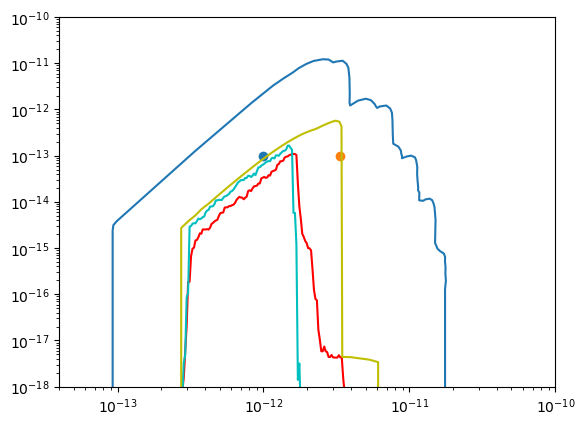

In [81]:

plt.plot(MashB, MashL, "r")
plt.plot(DodB, DodL, "c")
# plt.plot(MeB, MeL, "g")


plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-18, 1e-10])
plt.xlim([4e-14, 1e-10])
plt.plot(MLim[:,0], MLim[:,1], "y")

plt.scatter([1e-12], [1/1e13])
plt.scatter([2.5e-12 * (0.4 / .3)], [1/1e13])
plt.plot(DLim[:,0], DLim[:,1])


#plt.plot(DLim[:,0], DLim[:,1])
#plt.xlim([1e-20, 1e-17])

0.025

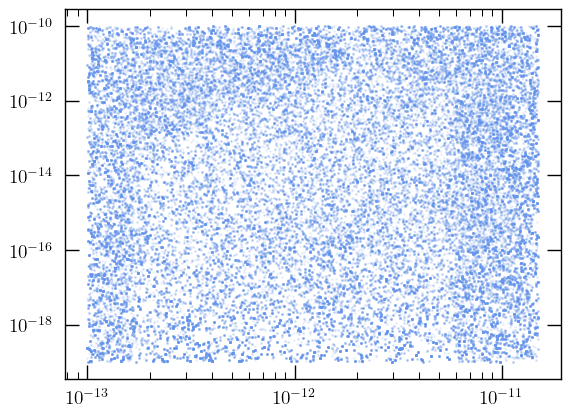

In [34]:

fileMCMC = np.loadtxt("../output_mcmc/Me_Cyg_N3_NR_2.dat")
plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=1, alpha=.1)
plt.yscale("log")
plt.xscale("log")

(1e-13, 1e-10)

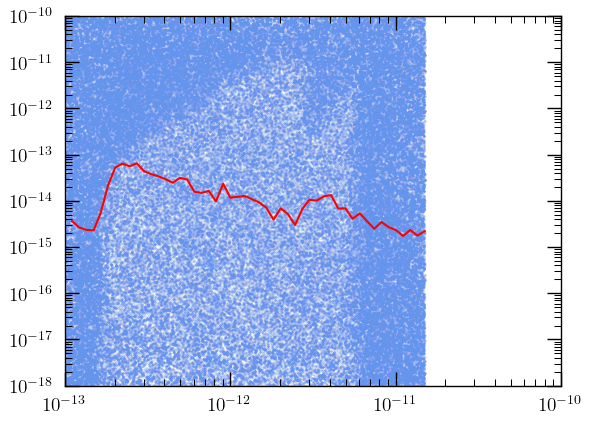

In [27]:
binN = 50 + 1
binE = np.linspace(np.min(fileMCMC[:,0]) , np.max(fileMCMC[:, 0]), binN)
binAv = np.diff(binE) + binE[:-1]
limV = np.zeros_like(binAv)
for i in range(len(binE) - 1):
    cond1 = fileMCMC[:,0] >= binE[i]
    cond2 = fileMCMC[:,0] <= binE[i+1]
    shortL = fileMCMC[np.all(np.column_stack((cond1, cond2)), axis=1), :]
    limV[i] = np.percentile(shortL[:,1], 50)
    
plt.scatter(10**fileMCMC[:,0], 1.0 / 10**fileMCMC[:,1], s=.1, alpha=0.1)
plt.plot(10**binAv, 1.0 / 10**limV, "r")
plt.yscale("log")
plt.xscale("log")
plt.ylim([1e-18, 1e-10])
plt.xlim([1e-13, 1e-10])

#plt.xlim([1e-20, 1e-17])

In [25]:
limV

array([18.55229766, 18.59318337, 18.5723877 , 18.57485651, 18.54616813,
       18.63760564, 18.3986999 , 18.53607495, 18.38823595, 18.4940495 ,
       18.54028073, 18.42136146, 18.51708815, 18.41200335, 18.41903654,
       18.44897137, 18.47341077, 18.58229836, 18.37514624, 18.45599838,
       18.35738664, 18.42271547, 18.579478  , 18.55332833, 18.53100105,
       18.55573633, 18.56081742, 18.61797613, 18.64797875, 18.49446696,
       18.4717473 , 18.63711016, 18.49367963, 18.56281057, 18.4927843 ,
       18.53806678, 18.55520546, 18.55782998, 18.56655958, 18.63396169,
       18.55382725, 18.54871165, 18.55265949, 18.50529772, 18.57112685,
       18.52250506, 18.60628552, 18.54554442, 18.60092333, 18.55781879])

In [62]:
filetest0 = np.loadtxt("../test_store/OutRun_fa_1.0e19_ma_2.5e-12_MBH_10.0_spin_0.9.dat")
#filetest1 = np.loadtxt("../test_store/OutRun_fa_5.0e14_ma_2.5e-12_MBH_10.0_spin_0.9.dat")
filetest2 = np.loadtxt("../test_store/OutRun_fa_5.0e12_ma_2.5e-12_MBH_10.0_spin_0.9.dat")
filetest3 = np.loadtxt("../test_store/OutRun_fa_1.0e11_ma_2.5e-12_MBH_10.0_spin_0.9.dat")

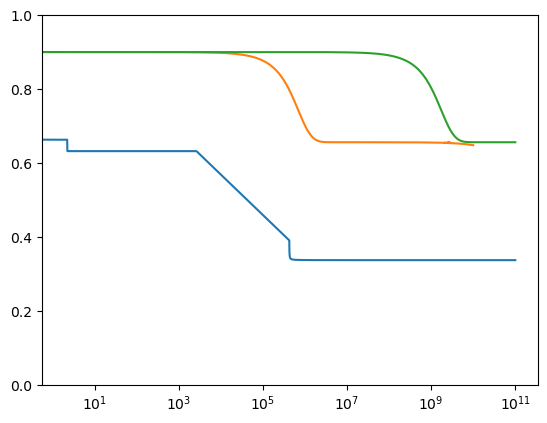

In [64]:
plt.plot(filetest0[:,0], filetest0[:,3])
#plt.plot(filetest1[:,0], filetest1[:,3])
plt.plot(filetest2[:,0], filetest2[:,3])
plt.plot(filetest3[:,0], filetest3[:,3])
plt.ylim([0,1])
plt.xscale("log")

(1e-20, 1)

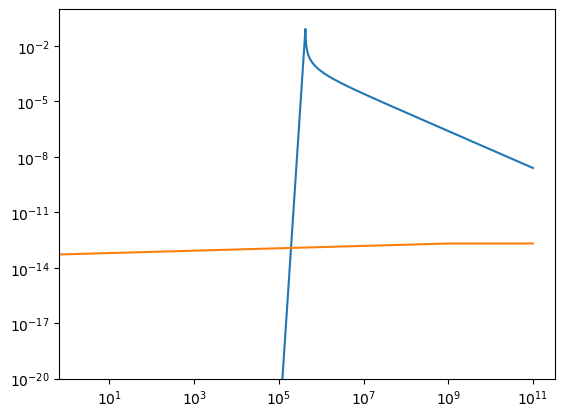

In [57]:
plt.plot(filetest0[:,0], filetest0[:,2])
#plt.plot(filetest1[:,0], filetest1[:,3])
#plt.plot(filetest2[:,0], filetest2[:,3])
plt.plot(filetest3[:,0], filetest3[:,2])
plt.ylim([0,1])
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-20, 1])

(1e-20, 1)

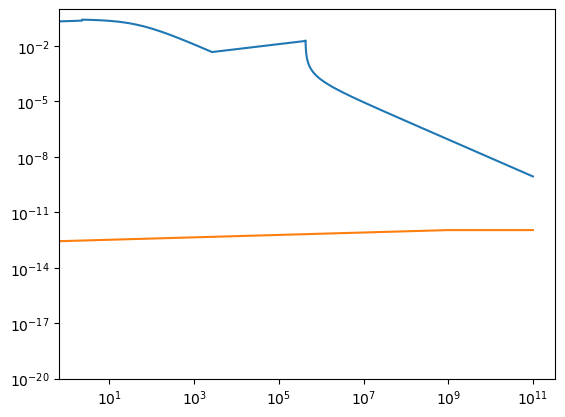

In [58]:
plt.plot(filetest0[:,0], filetest0[:,1])
#plt.plot(filetest1[:,0], filetest1[:,3])
#plt.plot(filetest2[:,0], filetest2[:,3])
plt.plot(filetest3[:,0], filetest3[:,1])
plt.ylim([0,1])
plt.xscale("log")
plt.yscale("log")
plt.ylim([1e-20, 1])

In [59]:
filetest3

array([[0.00000000e+00, 1.19095517e-78, 1.19095517e-78, 9.00000000e-01,
        1.00000000e+01],
       [1.00000000e+09, 1.09731957e-12, 2.06412266e-13, 8.03317568e-01,
        9.99971157e+00],
       [2.00000000e+09, 1.09731957e-12, 2.06412266e-13, 7.25938731e-01,
        1.00000883e+01],
       [3.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.84896650e-01,
        1.00017851e+01],
       [4.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.67180598e-01,
        1.00040722e+01],
       [5.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.60182306e-01,
        1.00028288e+01],
       [6.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.57519248e-01,
        1.00041841e+01],
       [7.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.56522585e-01,
        1.00058027e+01],
       [8.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.56156510e-01,
        1.00075654e+01],
       [9.00000000e+09, 1.09731957e-12, 2.06412266e-13, 6.56023052e-01,
        1.00007344e+01],
       [1.00000000e+10, 1.0973